## Introduction
This notebook was built for the Deep Learning Image Classification Challenge Project for Codecademy's "Build Deep Learning Models With Tensorflow" skill path. For this project, we were to build a CNN (Convolutional Neural Network) trained on a dataset consisting of lung x-rays to predict whether a patient has Covid, Pneumonia, or normal lungs. 

### Import libraries

In [175]:
import tensorflow as tf
from tensorflow import keras
import numpy as np


### Read, Batch and Perform Data Augmentations

In [176]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#class used for generating batches of augmented data which are used to help prevent overfitting
#data augmentations allow the data to be invariant to the agmentations performed
#found this article very helpful when deciding the augmentations to perform:
#https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/
train_data_gen = ImageDataGenerator(rescale=1.0/255.0, zoom_range=[0.95, 1.05],
                                             width_shift_range=0.1, height_shift_range=0.1, 
                                             brightness_range=(0.7, 1.5), rotation_range=10)
valid_data_gen = ImageDataGenerator(rescale=1.0/255.0)
#defining batch_size 
batch_size = 32
#Yields DirectoryIterator objects for batching and performing data augmentations
#If you want to save images to directory, uncomment the end of the train call to flow_from_directory and add ImageDataGenerator folder to directory
train = train_data_gen.flow_from_directory('/Users/valhalla/data_science/codeacademy/deep_learning/cc_lung_image_classification/train', shuffle=False, class_mode='categorical', color_mode='grayscale', target_size = (256,256), batch_size=batch_size, seed=42)#, save_to_dir='/Users/valhalla/data_science/codeacademy/deep_learning/cc_lung_image_classification/ImageDataGenerator') 
valid = valid_data_gen.flow_from_directory('/Users/valhalla/data_science/codeacademy/deep_learning/cc_lung_image_classification/test', shuffle=False, class_mode='categorical', color_mode='grayscale', target_size = (256,256), seed=42)

Found 251 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Augmentations performed:  
Rescaling: 1.0/255.0, Zoom: 0.95%-1.05%, width shift: 0.1%, height shift: 0.1%, brightness: 0.7%-1.5% , rotation: 10 degrees 

### Viewing Lung X-Ray Images


(32, 256, 256, 1)


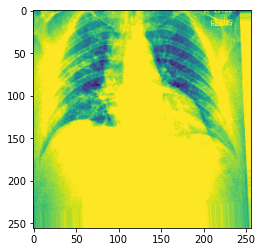

(32, 256, 256, 1)


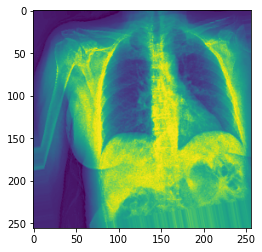

(32, 256, 256, 1)


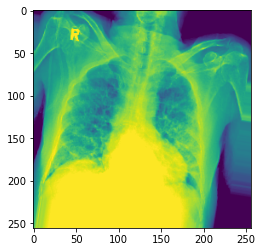

(32, 256, 256, 1)


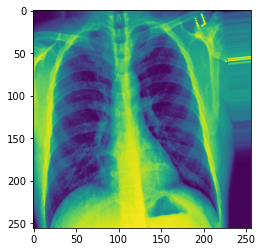

(32, 256, 256, 1)


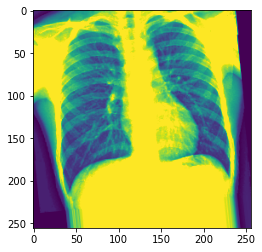

(32, 256, 256, 1)


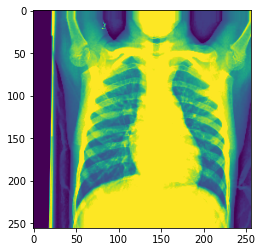

(32, 256, 256, 1)


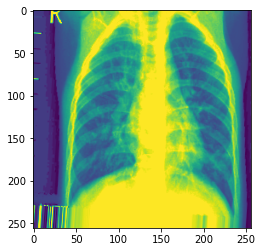

(32, 256, 256, 1)


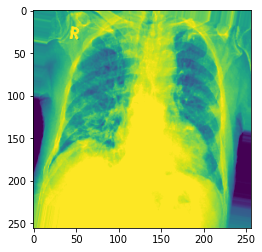

(32, 256, 256, 1)


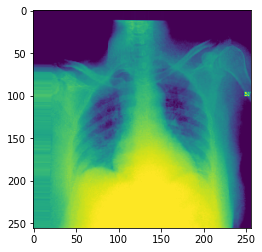

(32, 256, 256, 1)


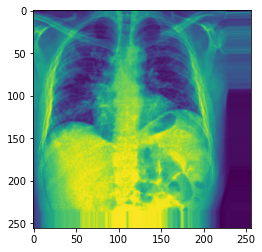

(32, 256, 256, 1)


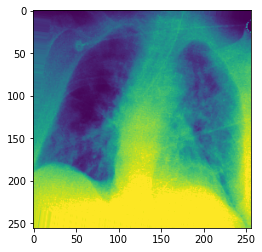

(32, 256, 256, 1)


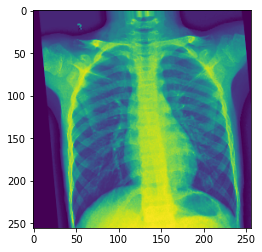

(32, 256, 256, 1)


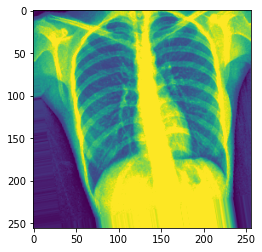

(32, 256, 256, 1)


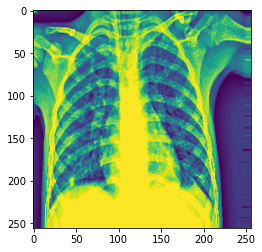

(32, 256, 256, 1)


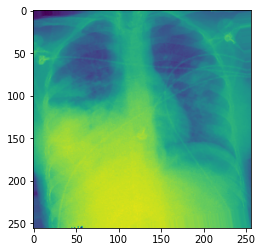

(32, 256, 256, 1)


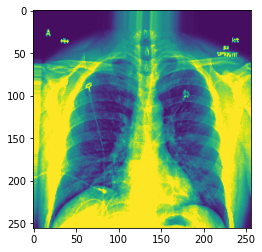

(32, 256, 256, 1)


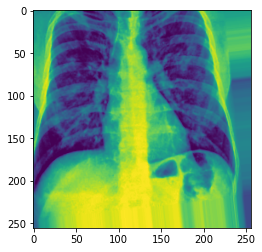

(32, 256, 256, 1)


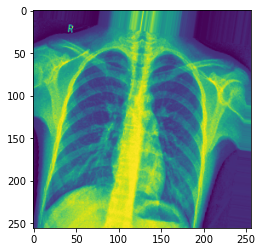

(32, 256, 256, 1)


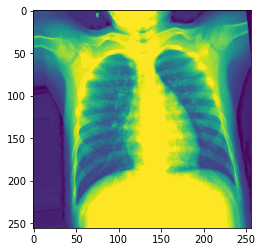

(32, 256, 256, 1)


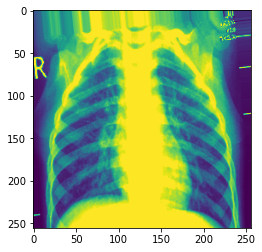

(32, 256, 256, 1)


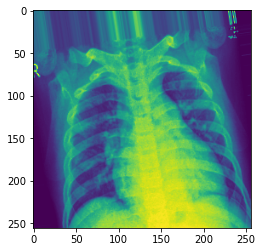

(32, 256, 256, 1)


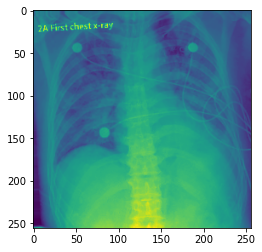

(32, 256, 256, 1)


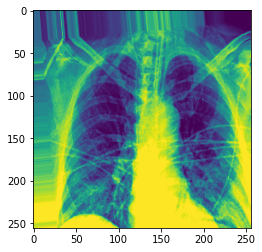

(32, 256, 256, 1)


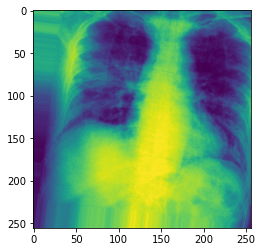

(32, 256, 256, 1)


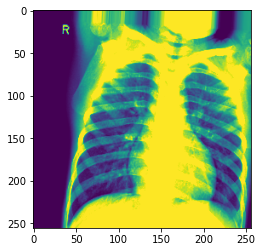

(32, 256, 256, 1)


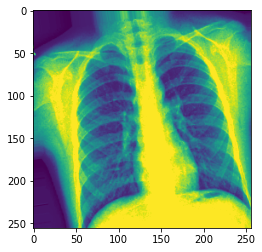

(32, 256, 256, 1)


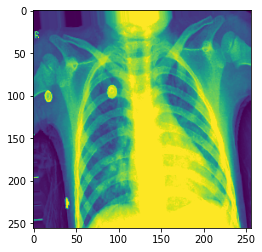

(32, 256, 256, 1)


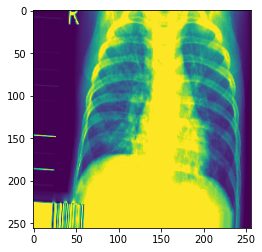

In [177]:
#'batch_size' = 32, but the next() iterator generates images having two different batch sizes as the last batch has 
#27 images, and all the rest have 32. Only keeping those with batch_size = 32 to visualize the convolutions later
from matplotlib import pyplot as plt

for i in range(batch_size):
    img, labels = train.next()
    if img.shape[0] == 32:
        print(img.shape)
        plt.imshow(np.squeeze(img[i]))#remove dimension to print images 
        plt.show()

Looking at the data, we not only see some of the augmentations performed, but we can also see some issues with our images that might disrupt performance such as text within the images and over exposure.

### Build the CNN

In [178]:
#import layers modules
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

#instantiate model and add all layers
model = tf.keras.Sequential()
#Input Layer
model.add(tf.keras.Input(shape=(256, 256, 1)))
#first convolution layer
model.add(Conv2D(16, 3, strides=1, activation="relu", padding='same')) 
#max pooling layer
model.add(MaxPooling2D(pool_size=(3, 3)))
#second convolution layer
model.add(Conv2D(32, 3, strides=1, activation="relu"))
#max pooling layer
model.add(MaxPooling2D(pool_size=(3,3)))
#third convolution layer
model.add(Conv2D(16, 5, strides=2, activation="relu")) 
#max pooling layer
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3)))
#Model must be flattened (turned into a 1-D array) before going into a Dense (full-connected) layer
model.add(Flatten())
# adding Dense Hidden Layer
model.add(tf.keras.layers.Dense(32, activation='relu'))
#Using softmax as output activation function as it is a multi-class classification problem
model.add(tf.keras.layers.Dense(3, activation="softmax"))

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 256, 256, 16)      160       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 85, 85, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 83, 83, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 12, 12, 16)        12816     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 256)              

#### Tips to understand model summary
grayscale so input has 1 channel  
Conv2d layers: output_channels * (input_channels * window_size + 1) = num_parameters  
Conv2d = 16 * (1 * (3*3) + 1)  
Conv2d = 32 * (16 * (3*3) + 1)  
Conv2d = 16 * (32 * (5*5) + 1)   

Dense layers: output_size * (input_size + 1) == num_parameters   
Dense = 16 * (256 + 1)  (256 comes from flattening the layers) 

output_size = ((input_size-kernel_size+2P)/S) + 1  
P = size f zero padding  
S = strides  

### Compile Model

In [179]:
#compiling model with metrics and optimizer
model.compile(
    optimizer=tf.keras.optimizers.Adam(),#learning_rate=0.005),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()])

#### Metrics
categorical crossentropy: Computes the crossentropy loss between the labels and predictions.  
categorical accuracy: Calculates how often predictions match the true labels.  

### 'ReduceLROnPlateau' and 'ModelCheckpoint'

Reduce learning rate on plateau will reduce the learning rate of the model when the loss parameter hits a plateau. The 'patience' parameter waits 100 epochs before stopping training the model. I am using this in conjunction with 'ModelCheckpoint' as this will create a checkpoint and save the weights where 'val_loss' is the lowest. These weights will then be loaded into the model.

#### 'ReduceLROnPlateau'

In [180]:
#Reduce learning rate on plateau reduces the learnig rate when the loss parameter does not get better
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose=0, patience=100, factor=0.2)

#### ModelCheckpoint

In [181]:
#Model checkpoint stores the model weights during the best epoch to feed into the model later
#the weights are stored in an hdf5 file 
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('weights.hdf5', monitor='val_loss', save_best_only=True)

### Fit the model

Fitting the model with the callbacks 'ReduceLROnPlateau' and 'ModelCheckpoint'

In [182]:
#fitting the model using Reduce learning rate and model checkpoint.
history = model.fit(
       train,
       steps_per_epoch=train.samples/batch_size,
       epochs=500, 
       validation_data=valid, verbose=0, callbacks = [reduce_lr,checkpoint])

### Model Evaluation

##### Visualizing loss parameters

Text(0, 0.5, 'Categorical Accuracy')

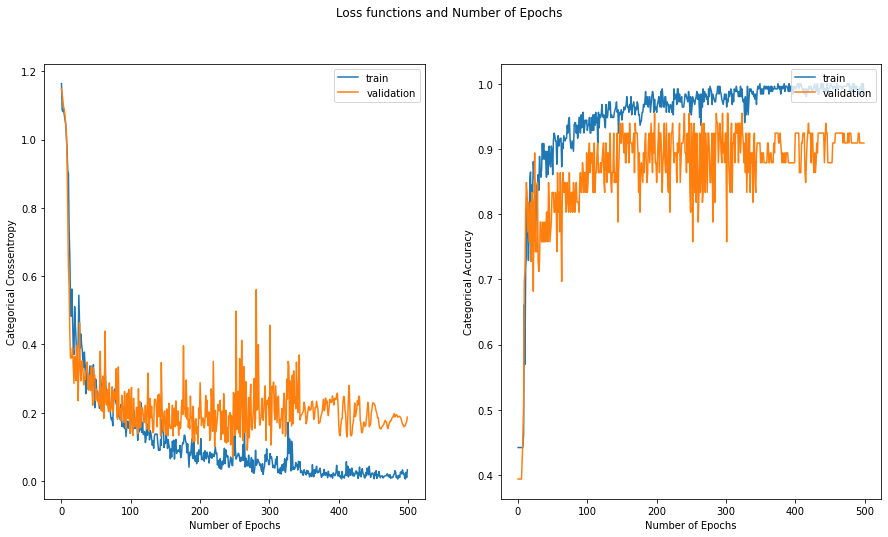

In [183]:
#Visualizing the loss parameters
#creating figure area for 2 plots side-by-side
fig, axs = plt.subplots(1,2, figsize=(15, 8))
plt.suptitle('Loss functions and Number of Epochs')
(ax1, ax2) = axs

#first plot Categorical Crossentropy vs epochs
ax1.plot(history.history['loss'], label='train')
ax1.plot(history.history['val_loss'], label='validation')
ax1.legend(loc="upper right")
ax1.set_xlabel('Number of Epochs')
ax1.set_ylabel('Categorical Crossentropy')

#second plot categorical accuracy vs epochs
ax2.plot(history.history['categorical_accuracy'], label='train')
ax2.plot(history.history['val_categorical_accuracy'], label='validation')
ax2.legend(loc="upper right")
ax2.set_xlabel('Number of Epochs')
ax2.set_ylabel('Categorical Accuracy')

#### Load Checkpoint Weights

In [184]:
# loading the model with the weights that minimized 'val_loss'
model.load_weights('weights.hdf5')

#### Visualize a Convolution

Fifth image from training data with the first convolutional layer convolved over it

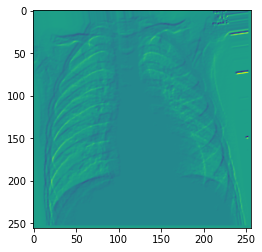

In [185]:
#Visualization of convolution
#retrieving a convolutional layer
conv_1 = model.layers[2]
#Getting the weights of the first convolutional layer
weight_1 = conv_1.get_weights()
#kernel for convolution
kernel = weight_1[0][...,0,0] #The ellipsis syntax indicates selecting any remaining unspecified dims
#instantiating numpy array to convolve over
result = np.zeros(shape=(img.shape[1], img.shape[2]))

def convolution(img, kernel):
    img_stripped = np.squeeze(img)
    for i in range(img_stripped.shape[0] - 3):
        for j in range(img_stripped.shape[1] - 3):
            window = img_stripped[i:i+3, j:j+3] 
            result[i, j] = (window * kernel).sum()
    return result
  
#convolve with 5th image in train_data
out = convolution(img[5, :, :, :], kernel)
plt.imshow(out)
plt.show()

Original Image 

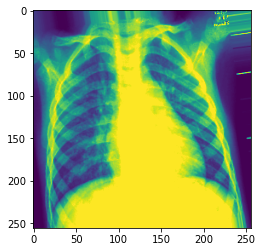

In [186]:
#Show ith image before convolution
plt.imshow(np.squeeze(img[5]))
plt.show()

#### Evaluation Metrics

We want to know if the class predicted is correct and therefore we care about a high precision. But precision has its
downfalls, e.g. if a model predicts all true for a specific class then the precision will be 1, even if the data 
has some false values in it. Therefore precision needs to be balanced with recall and that is where the F1 score comes in as it is the harmonic avg between precision and recall.

3/3 [==============================] - 0s 89ms/step - loss: 0.0698 - categorical_accuracy: 0.9545
0.06984655602718703

The categorical accuracy or how often the predictions match the labels is 95%

The predicted values are:
[0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

The actual values are:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.95      0.95      0.95        20
           2       0.90      0.95      0.93        20

    accuracy                           0.95        66
   macro avg       0.95      0.95      0.95        66
weighted avg       0.96      0.95      0.95        66



[Text(0, 0.5, 'Covid'), Text(0, 1.5, 'Normal'), Text(0, 2.5, 'Pneumonia')]

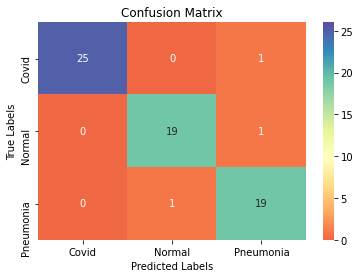

In [187]:
from sklearn.metrics import classification_report,  confusion_matrix, f1_score
import seaborn as sns


#evaluating the model
loss, acc = model.evaluate(valid)
print(loss)
print('')
print('The categorical accuracy or how often the predictions match the labels is ' + f'{acc*100:.{0}f}' + '%')
print('')
#getting predictions for futher evaluation
preds = model.predict(valid)
preds = np.argmax(preds, axis=1)
#looking at the values that were predicted and the true values
print('The predicted values are:')
print(preds)
print('')
print('The actual values are:')
print(valid.classes)
print('')
print('Classification Report:')
print(classification_report(valid.classes, preds, labels=[0,1,2]))
#f1 score: The weighted avg of precision and recall where each have the same weight best at 1 and worse at 0. Each 
#class has its own F1 score. F1 = 2 * (precision * recall) / (precision + recall). This is good when the classes are 
#are skewed. Recall is sensitivty or TPR (True Positive Rate = TP/(TP+FN)). Precision = TP/(TP+FP)

#creating confusion matrix plot with sns
cm=confusion_matrix(valid.classes, preds)
ax = plt.subplot()
sns.heatmap(cm, vmin=0, vmax=26, center=10, cmap="Spectral", annot=True)
ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['Covid', 'Normal', "Pneumonia"]) 
ax.yaxis.set_ticklabels(['Covid', 'Normal', "Pneumonia"])

#macro avg is the usual avg, weighted avg takes into account how many were in each class when averaging


### Conclusions

In [188]:
print('The categorical accuracy of the model is ' + f'{acc*100:.{0}f}' + '%. For such a small dataset, I am impressed with the \
model\'s ability to predict whether a person has Covid, Pneumonia, or Neither.')


The categorical accuracy of the model is 95%. For such a small dataset, I am impressed with the model's ability to predict whether a person has Covid, Pneumonia, or Neither.


The model has skewed classes and therefore the f1 parameter is used as an indicator of model performance. The highest f1 score possible is 1, and all three of our classes had f1 scores of around .9. While these seem like high f1 scores,  in the medical industry we need our model to be even higher. When a model incorrectly diagnoses medical data the patient will receive improper treatment or no treatment at all, which can have dire results. The confusion matrix shows how many incorrect classifications the model predicted, those not along the diagonal.

In order for this model to be even better, it would be worthwhile to gather more data and look further at model architectures. I have tried many architectures and this is the one that I got the best results with.

